In [13]:
#Importing necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter

In [14]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

In [15]:
#reading the original image using OpenCV
image = cv2.imread('Original.jpg')

In [16]:
#Converting the colored image to greyscale
angle, rotated = correct_skew(image)
print(angle)
cv2.imwrite('rotated.jpg', rotated)
gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

-1


In [17]:
# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(rotated, [c], -1, (255,255,255), 5)

In [18]:
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(rotated, [c], -1, (255,255,255), 5)

In [19]:
gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)

In [20]:
#applying median filter for Salt and pepper/impulse noise
filter1 = cv2.medianBlur(gray,5)

In [21]:
#applying gaussian blur to smoothen out the image edges
filter2 = cv2.GaussianBlur(filter1,(5,5),0)

In [22]:
#applying non-localized means for final Denoising of the image
dst = cv2.fastNlMeansDenoising(filter2,None,17,9,17)

In [23]:
#converting the image to binarized form using adaptive thresholding
th1 = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

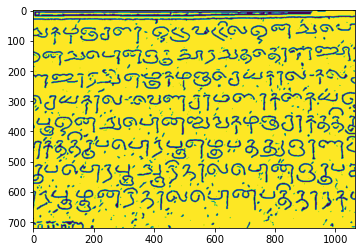

In [24]:
img = cv2.imwrite('ImagePreProcessingFinal.jpg', th1)
plt.imshow(th1)
plt.show()